In [123]:
import os
os.environ["OMP_NUM_THREADS"]='1'
import osmnx as ox
import networkx as nx

import pandas as pd
import geopandas as gpd

from pyproj import Transformer 
import numpy as np
import scipy
from descartes import PolygonPatch

import matplotlib.pyplot as plt
from matplotlib import *
from matplotlib.patches import *
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors

import contextily as cx #Copyright (c) 2016, Dani Arribas-Bel. All rights reserved.

import math
import itertools
from shapely.geometry import MultiPolygon, Polygon, Point, LineString
from shapely.ops import nearest_points
from IPython.display import Image, IFrame

from sklearn import cluster
from sklearn.cluster import KMeans


import pandapower as pp
from pandapower.plotting import simple_plot, simple_plotly, pf_res_plotly 


ALKIS Daten

In [140]:
#ALKIS Daten importieren
polygon = gpd.read_file(r".\Daten\Weilimdorf")
#Polygon als Polygon-Objekt
new_poly = polygon["geometry"].iloc[0]
#Konvertierung in metrisches System
alkis = polygon.to_crs(epsg=25832)

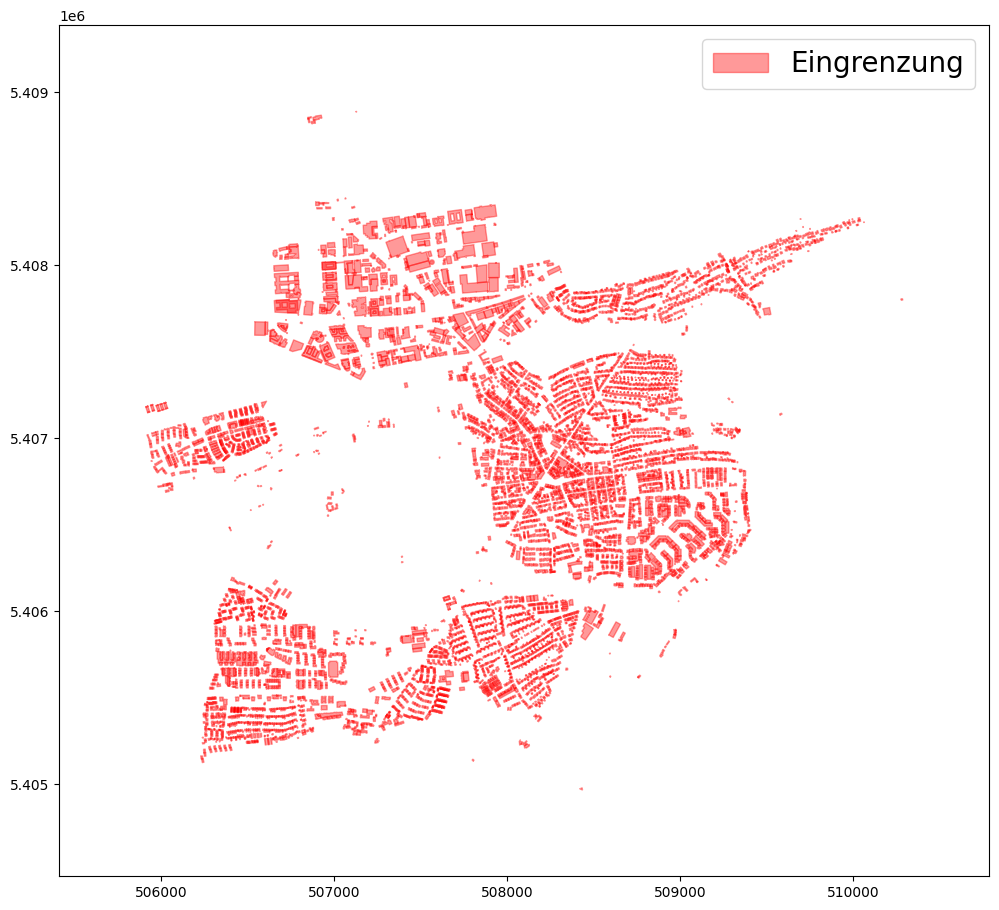

In [141]:
# PLOT DER EINGRENZUNG
# geometrische Form des Polygons
polygon_geometry = alkis.unary_union
#Min & Max x,y werte des Polygons
min_x, min_y, max_x, max_y = polygon_geometry.bounds

zoom_factor = 500
#neue Eingrenzungen des Plots
new_min_x = min_x-zoom_factor
new_max_x = max_x+zoom_factor
new_min_y = min_y-zoom_factor
new_max_y = max_y+zoom_factor


coordinates = [
    (min_x, max_y),
    (min_x, min_y),
    (max_x, min_y),
    (max_x, max_y),
    (min_x, max_y)
]

geometry = Polygon(coordinates)

polygon2 = gpd.GeoDataFrame(index=[0],geometry=[geometry])
polygon2.crs = "EPSG:25832"
#Polygon als Polygon-Objekt
new_poly2 = polygon2["geometry"].iloc[0]

boundaries = polygon2.to_crs(epsg="4326")

fig, ax=plt.subplots(1, figsize=(12,15))
alkis.plot(ax=ax, edgecolor='red', facecolor='red', alpha=0.4)
#polygon2.plot(ax=ax, edgecolor='red', facecolor='red', alpha=0.2)
#ax.set_axis_off()

ax.set_xlim(new_min_x, new_max_x)
ax.set_ylim(new_min_y, new_max_y)

legend_elements= [Patch(edgecolor='red', facecolor='red', alpha =0.4, label='Eingrenzung')]
ax.legend(handles=legend_elements, loc='upper right', fontsize=20)

plt.show()

OSM Daten

In [142]:
#alle Gebäude innerhalb des Polygons erfassen
buildings = ox.features.features_from_polygon(boundaries.geometry.iloc[0], tags={"building":True})

#Auf wichtigste Columns beschränken:
buildings = buildings.filter(['geometry', 'nodes', 'building','building:levels','power', 'ways', axis=='columns'])

#Alle NaN Stockwerkwerte mit 1 ersetzen:
buildings[['building:levels']] = buildings[['building:levels']].fillna(int(1))

In [143]:
#Gebäudezentren bestimmen
#buildings = buildings.to_crs(epsg=4326)
centroid_calc = buildings.to_crs(epsg=25832)#4326
centroids = centroid_calc.centroid
lons = list(centroids.x)
lats = list(centroids.y)

building_coords = [[lons[i],lats[i]] for i in range(len(lons))]
buildings = buildings.to_crs(epsg=25832)
#print(building_coords)

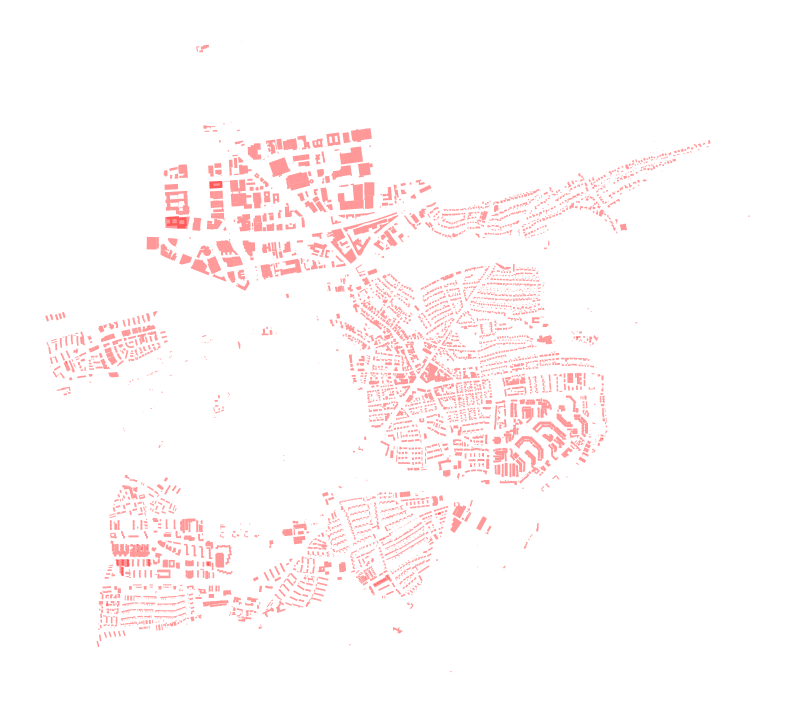

In [144]:
fig, ax = plt.subplots(figsize=(10, 10))

# Heatmap mit GeoDataFrame und last_kW als Farbzuweisung
#buildings.plot(ax=ax,legend=False)
alkis.plot(ax=ax, facecolor='red', alpha=0.4)
#polygon2.plot(ax=ax,legend=False,alpha=0.2)


ax.set_axis_off()

#plt.savefig(r'.\Daten\heatmap_erzeugung.png', format='png', bbox_inches='tight')
plt.show()
#print(build

Zuordnen

In [145]:
def assign_function_to_building(buildings_gdf,alkis_gdf):
    #ordnet Gebäuden das Passende Alkis Gebäude bzw. dessen Funktion zu 

    # Initialisiere die neue Spalte 'function' mit None
    buildings_gdf['function'] = None

    # Iteriere durch jedes Gebäude
    for idx, building in buildings_gdf.iterrows():
        
        # Finde alle ALKIS Polygone, die sich mit dem aktuellen Gebäude überschneiden
        overlapping_alkis = alkis_gdf[alkis_gdf.intersects(building.geometry)]
        
        if not overlapping_alkis.empty:
            # Falls es Überschneidungen gibt, nehme den Wert der Spalte 'funktion' des ersten überschneidenden Polygons
            buildings_gdf.at[idx, 'function'] = overlapping_alkis.iloc[0]['funktion']

    return buildings_gdf

In [146]:
updated_buildings = assign_function_to_building(buildings,alkis)

In [147]:
def assign_nearest_function(buildings_gdf):
    buildings_with_function = buildings_gdf[buildings_gdf['function'].notnull()]
    buildings_without_function = buildings_gdf[buildings_gdf['function'].isnull()]

    for idx, building in buildings_without_function.iterrows():
        # Berechne die Entfernung zu allen Gebäuden mit Funktion und finde die nächste
        nearest_building = buildings_with_function.distance(building.geometry).idxmin()
        
        # Weise die Funktion des nächsten Gebäudes zu
        nearest_function = buildings_with_function.loc[nearest_building, 'function']
        buildings_gdf.at[idx, 'function'] = nearest_function
    
    return buildings_gdf


In [148]:
def count_building_functions(buildings_gdf):
    # Zähle die Häufigkeit der verschiedenen Gebäudetypen
    function_counts = buildings_gdf['function'].value_counts().reset_index()
    function_counts.columns = ['function', 'count']
    return function_counts

In [149]:
all_buildings_with_function = assign_nearest_function(updated_buildings)
function_counts = count_building_functions(all_buildings_with_function)

# Tabelle ausgeben
print(function_counts)

                                         function  count
0                                        Wohnhaus   5069
1                                          Garage   1617
2                                 Betriebsgebäude    397
3                      Gebäude für Vorratshaltung    317
4                      Wohn- und Geschäftsgebäude    244
5                                        Wohnheim    233
6                                      Tiefgarage    206
7                                        Schuppen    183
8                                       Werkstatt    103
9                                     Bürogebäude     71
10                                          Stall     34
11                          Wohn- und Bürogebäude     30
12                      Wohn- und Betriebsgebäude     29
13                               Geschäftsgebäude     28
14                         Treibhaus, Gewächshaus     22
15  Kinderkrippe, Kindergarten, Kindertagesstätte     22
16                      Allgeme

In [150]:
def plot_building_functions(buildings_gdf,selected_function):
    # Einzigartige Gebäudetypen und ihre Farben definieren
    unique_functions = buildings_gdf[selected_function].unique()
    num_colors = len(unique_functions)
    colors = plt.cm.hsv(np.linspace(0, 1, num_colors))
    color_dict = dict(zip(unique_functions, colors))

    # Plot initialisieren
    fig, ax = plt.subplots(figsize=(12, 12))

    # Durch die Gebäudetypen iterieren und jeden Typ plotten
    for function, color in color_dict.items():
        subset = buildings_gdf[buildings_gdf[selected_function] == function]
        subset.plot(ax=ax, color=color, label=function)

    # Manuelle Erstellung der Legende
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=function)
               for function, color in color_dict.items()]
    
    # Erstellen einer mehrspaltigen Legende
    ax.legend(handles=handles, title='Gebäudetypen', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, fontsize='small', frameon=False)
    ax.set_axis_off()
    
    # Titel hinzufügen
    plt.title('Gebäude nach Funktion')
    plt.show()

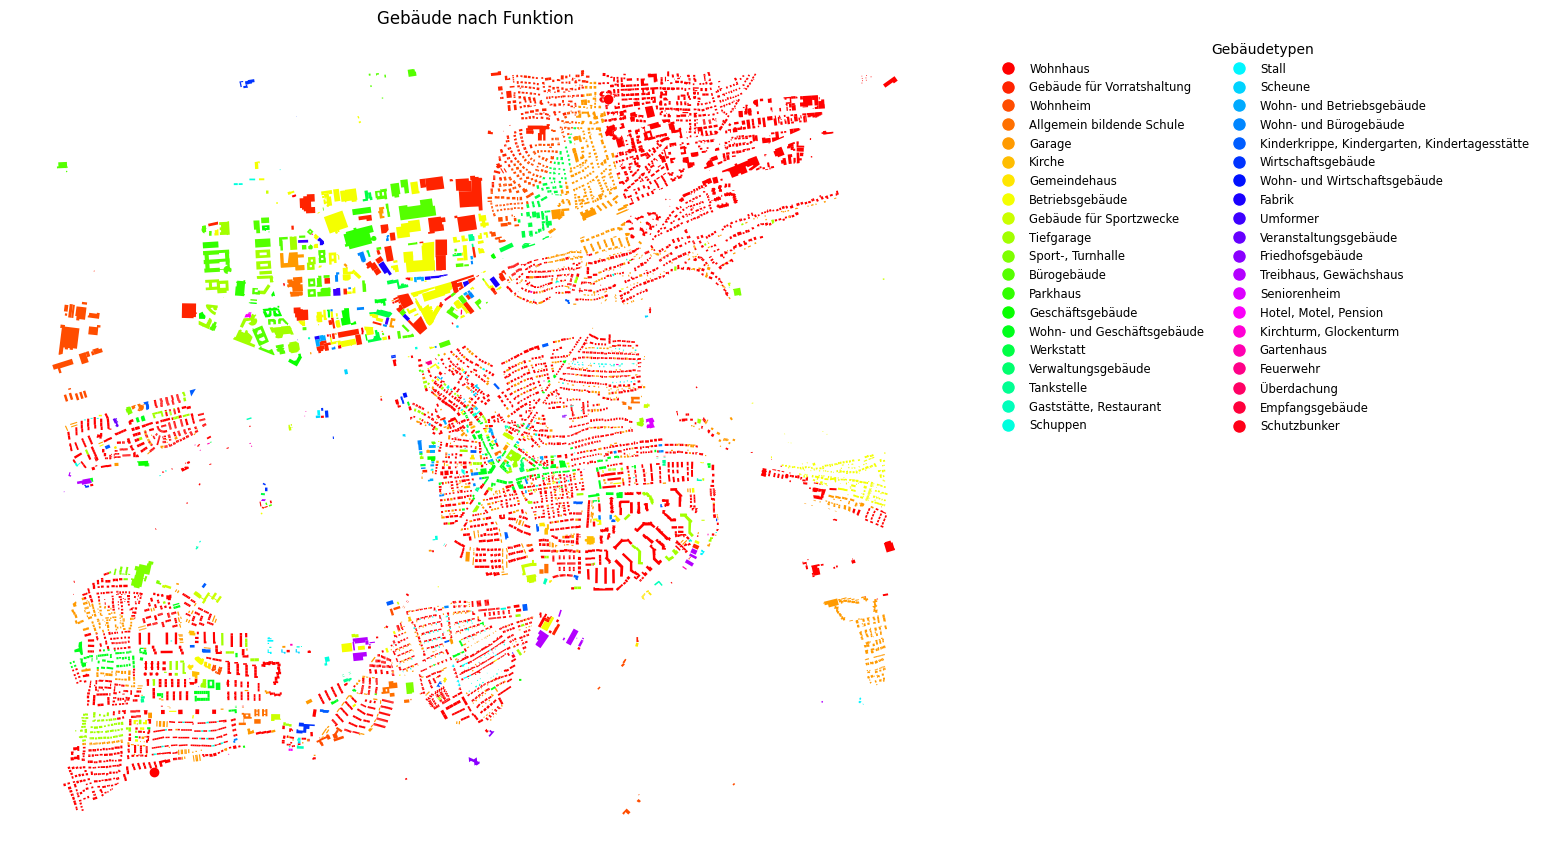

In [151]:
plot_building_functions(all_buildings_with_function,'function')